# Gesture Recognition

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up: Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds
- Stop: Pause the movie

In [1]:
# Importing the necessary libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 8 

# Data Preprocessing

In [4]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [5]:
# Resize,crop and normalize the images
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [6]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

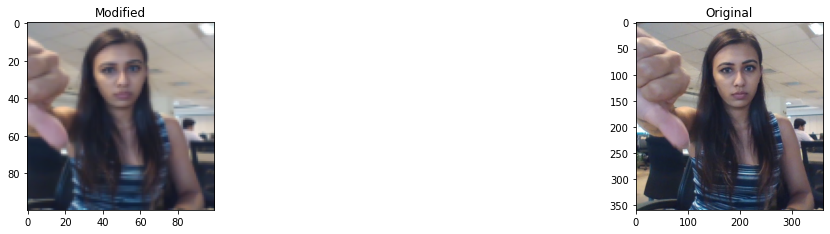

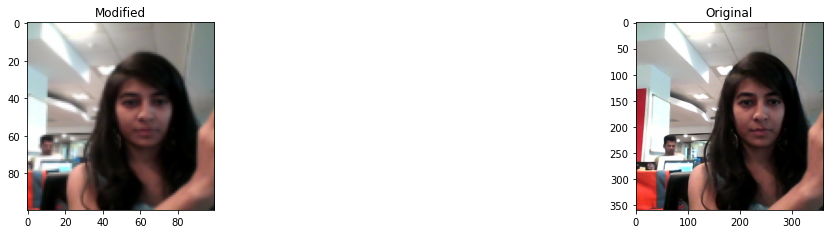

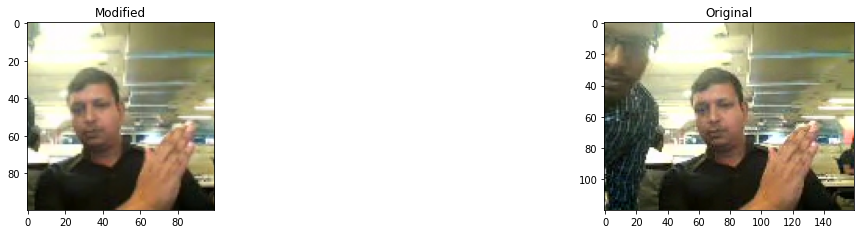

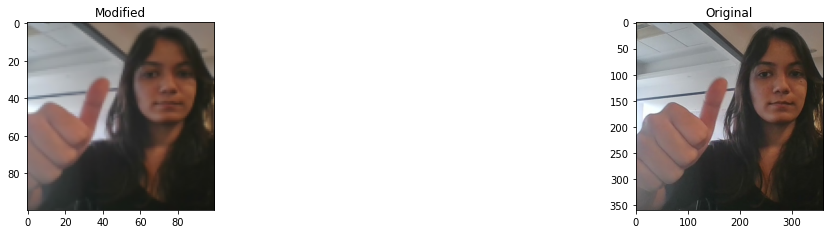

In [7]:
paths = ["datasets/Project_data/train/WIN_20180907_15_53_00_Pro_Thumbs Down_new/WIN_20180907_15_53_00_Pro_00001.png",
        "datasets/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "datasets/Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "datasets/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)

# Generator

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# Model Building

# Model - 1 

Here we make the model using different functionalities that Keras provides.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

2023-09-03 10:53:29.822803: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-03 10:53:29.823234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [11]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 15, 100, 100, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 50, 50, 16)    6

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/25


2023-09-03 10:53:32.423166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


83/83 [==============================] - ETA: 0s - loss: 1.7802 - categorical_accuracy: 0.2127Source path =  datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.58813, saving model to model_init_2023-09-0310_53_28.811303/model-00001-1.78022-0.21267-1.58813-0.27000.h5
83/83 [==============================] - 85s 988ms/step - loss: 1.7802 - categorical_accuracy: 0.2127 - val_loss: 1.5881 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5866 - categorical_accuracy: 0.2565
Epoch 00002: val_loss improved from 1.58813 to 1.45833, saving model to model_init_2023-09-0310_53_28.811303/model-00002-1.58659-0.25645-1.45833-0.36538.h5
83/83 [==============================] - 65s 793ms/step - loss: 1.5866 - categorical_accuracy: 0.2565 - val_loss: 1.4583 - val_categorical_accuracy: 0.3654 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.5751 - categorical_accura

**Training Accuracy:** 0.45%

**Validation Accuracy:** 0.67%

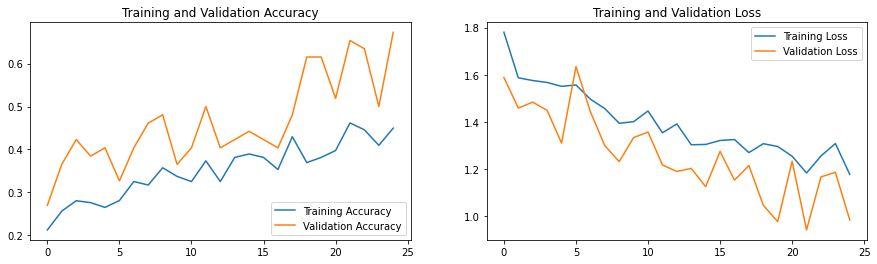

In [16]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters



# MODEL - 2 

We are going to reducing the size of the image from 100 to 50

In [17]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

In [18]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))


In [19]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_3 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_4 (Batc  (None, 7, 25, 25, 16)   

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9575 - categorical_accuracy: 0.1931Source path =  datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.60531, saving model to model_exp2_2023-09-0310_53_28.811303/model-00001-1.95748-0.19306-1.60531-0.20000.h5
83/83 [==============================] - 102s 1s/step - loss: 1.9575 - categorical_accuracy: 0.1931 - val_loss: 1.6053 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6086 - categorical_accuracy: 0.2341
Epoch 00002: val_loss improved from 1.60531 to 1.56421, saving model to model_exp2_2023-09-0310_53_28.811303/model-00002-1.60856-0.23408-1.56421-0.25000.h5
83/83 [==============================] - 86s 1s/step - loss: 1.6086 - categorical_accuracy: 0.2341 - val_loss: 1.5642 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
83/83 [===========

**Training Accuracy:** 0.5%

**Validation Accuracy:** 0.58%

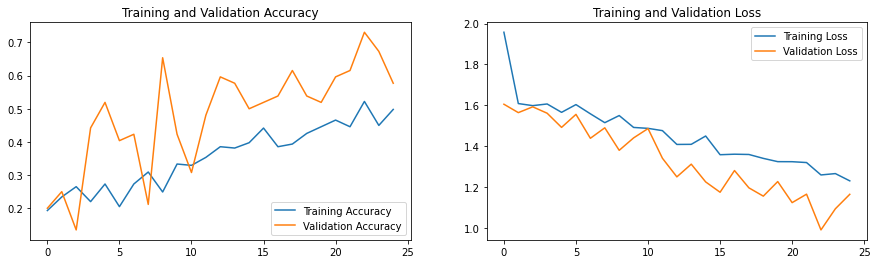

In [24]:
plot_history(history)

As we can see scaling to smaller images work better

# MODEL - 3

Now we decrease the batch size from 8 to 4

In [25]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [26]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [27]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_6 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_7 (Batc  (None, 7, 25, 25, 16)   

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7733 - categorical_accuracy: 0.2157Source path =  datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.56531, saving model to model_exp3_2023-09-0310_53_28.811303/model-00001-1.77330-0.21569-1.56531-0.18000.h5
166/166 [==============================] - 77s 465ms/step - loss: 1.7733 - categorical_accuracy: 0.2157 - val_loss: 1.5653 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.2390
Epoch 00002: val_loss improved from 1.56531 to 1.52222, saving model to model_exp3_2023-09-0310_53_28.811303/model-00002-1.59653-0.23896-1.52222-0.25000.h5
166/166 [==============================] - 80s 482ms/step - loss: 1.5965 - categorical_accuracy: 0.2390 - val_loss: 1.5222 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
166/1

**Training Accuracy:** 0.52%

**Validation Accuracy:** 0.76%

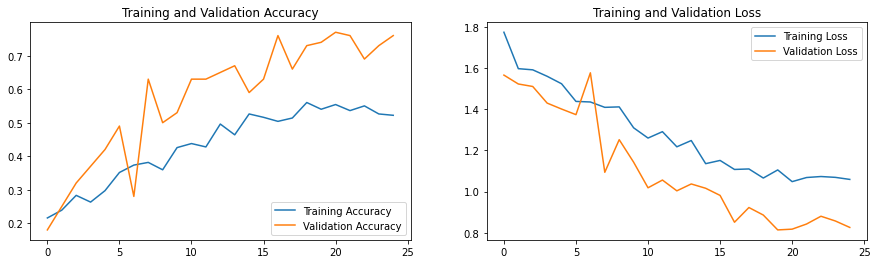

In [32]:
plot_history(history)

As we can see here reducing the batch size has reduced overfitting and increase the accuracy

# MODEL - 4 

Now we change the optimizer from SGD to Adam

In [33]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [34]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 25, 25, 16)   

In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8046 - categorical_accuracy: 0.1870Source path =  datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.57858, saving model to model_exp4_2023-09-0310_53_28.811303/model-00001-1.80456-0.18703-1.57858-0.28000.h5
166/166 [==============================] - 77s 466ms/step - loss: 1.8046 - categorical_accuracy: 0.1870 - val_loss: 1.5786 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6132 - categorical_accuracy: 0.2269
Epoch 00002: val_loss did not improve from 1.57858
166/166 [==============================] - 62s 374ms/step - loss: 1.6132 - categorical_accuracy: 0.2269 - val_loss: 1.5976 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6032 - categorical_accuracy: 0.2510
Epoch

**Training Accuracy:** 0.53%

**Validation Accuracy:** 0.57%

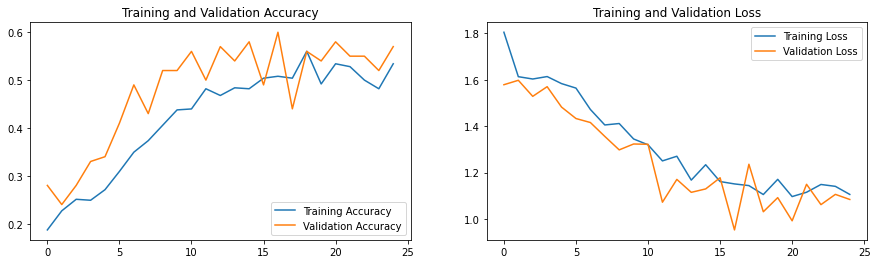

In [39]:
plot_history(history)

Adam has reduced overfitting. However since the accuracy has been constantly improving we might need to increase the number of epochs in a later experiment

# MODEL - 5

Now we reducing the number of frames from 15 to 10

In [40]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [41]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_12 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_13 (Bat  (None, 5, 25, 25, 16)   

In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [43]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [45]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8232 - categorical_accuracy: 0.2278Source path =  datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.58667, saving model to model_exp5_2023-09-0310_53_28.811303/model-00001-1.82317-0.22775-1.58667-0.24000.h5
166/166 [==============================] - 53s 317ms/step - loss: 1.8232 - categorical_accuracy: 0.2278 - val_loss: 1.5867 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6045 - categorical_accuracy: 0.2390
Epoch 00002: val_loss improved from 1.58667 to 1.58511, saving model to model_exp5_2023-09-0310_53_28.811303/model-00002-1.60447-0.23896-1.58511-0.24000.h5
166/166 [==============================] - 42s 254ms/step - loss: 1.6045 - categorical_accuracy: 0.2390 - val_loss: 1.5851 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/

**Training Accuracy:** 0.5%

**Validation Accuracy:** 0.68%

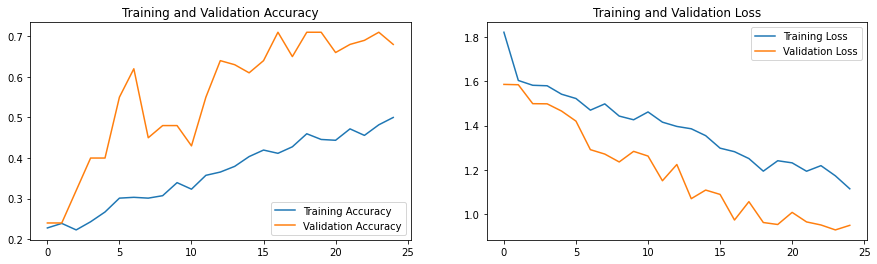

In [46]:
plot_history(history)

The Validation Accuracy increased from 0.57% to 0.68%

# MODEL - 6 

Now we reducing the dropout rate from 0.5 to 0.25

In [47]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [48]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Bat  (None, 5, 25, 25, 16)   

In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [52]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.6771 - categorical_accuracy: 0.2262Source path =  datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.46791, saving model to model_exp6_2023-09-0310_53_28.811303/model-00001-1.67708-0.22624-1.46791-0.31000.h5
166/166 [==============================] - 53s 317ms/step - loss: 1.6771 - categorical_accuracy: 0.2262 - val_loss: 1.4679 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.4849 - categorical_accuracy: 0.3414
Epoch 00002: val_loss improved from 1.46791 to 1.40017, saving model to model_exp6_2023-09-0310_53_28.811303/model-00002-1.48493-0.34137-1.40017-0.39000.h5
166/166 [==============================] - 43s 258ms/step - loss: 1.4849 - categorical_accuracy: 0.3414 - val_loss: 1.4002 - val_categorical_accuracy: 0.3900 - lr: 2.0000e-04
Epoch 3/

**Training Accuracy:** 0.89%

**Validation Accuracy:** 0.86%

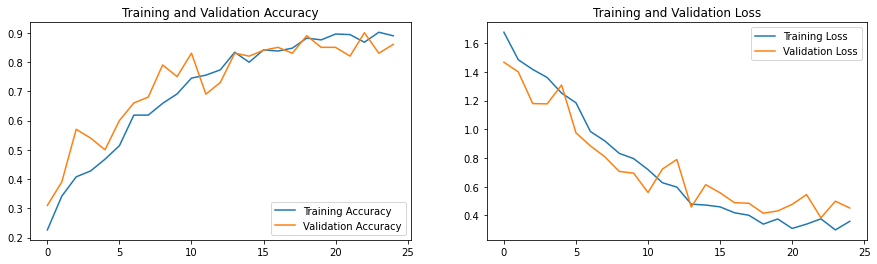

In [53]:
plot_history(history)

A drop out rate of 0.25 gives our model better training and validation accuracy 

# MODEL - 7 

Now we increasing the number of epochs from 25 to 35

In [54]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [55]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_18 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_19 (Bat  (None, 5, 25, 25, 16)   

In [56]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [57]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [58]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [59]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.7449 - categorical_accuracy: 0.2474Source path =  datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.54460, saving model to model_exp7_2023-09-0310_53_28.811303/model-00001-1.74490-0.24736-1.54460-0.31000.h5
166/166 [==============================] - 53s 317ms/step - loss: 1.7449 - categorical_accuracy: 0.2474 - val_loss: 1.5446 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.5303 - categorical_accuracy: 0.3394
Epoch 00002: val_loss improved from 1.54460 to 1.45464, saving model to model_exp7_2023-09-0310_53_28.811303/model-00002-1.53029-0.33936-1.45464-0.40000.h5
166/166 [==============================] - 42s 254ms/step - loss: 1.5303 - categorical_accuracy: 0.3394 - val_loss: 1.4546 - val_categorical_accuracy: 0.4000 - lr: 2.0000e-04
Epoch 3/

**Training Accuracy:** 0.86%

**Validation Accuracy:** 0.78%

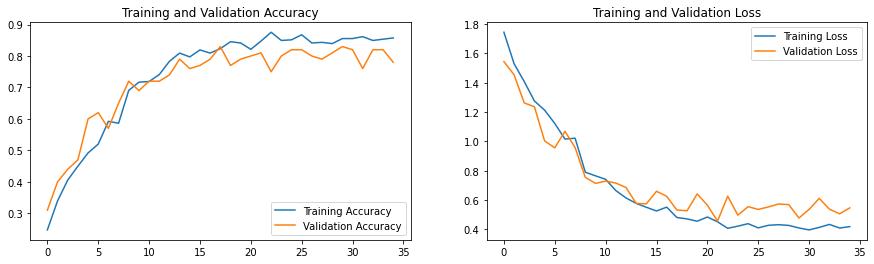

In [60]:
plot_history(history)

After 35 epochs the training and validation accuracy changes to 0.86% and 0.78% respectively and it mean that our model is generalizing adequately to unseen data.

Conclusion: -
- We selected the Model 6 as our final model as it achieved a training accuracy of 0.89 and validation accuracy of 0.86, which suited our requirements.
